In [1]:
import pandas as pd

df = pd.read_csv('../data/sales.csv')
df.dropna(subset=['price'], inplace=True)

In [2]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [3]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

In [4]:
train_raw.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth,year
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm,2008
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm,1997
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm,2001
3,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm,2000
4,$59k,"$60,320",2 Ton 930 Kg,Aug 19 2011,H,super advanced,M14124,"IN732067,IN732068,IN732069,IN732070,IN732071,I...",2.71 meters,96 cm,25 cm,2011


# 1. Cost Transformation Class

**Example:** Cost Transformer. Because we need to use it with **Pipeline**, we need both X and y in the functions **fit**, **transform**, and **fit_transform**.

In [5]:
class Cost_Transformer(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

In [6]:
ctf = Cost_Transformer()

In [7]:
ctf.fit_transform(train_raw).head()

,cost
0,333000.000000
1,166184.183143
2,270000.000000
3,97000.000000
4,59000.000000


In [8]:
ctf.transform(test_raw).head()

,cost
0,166184.183143
1,160000.000000
2,160000.000000
3,166184.183143
4,18000.000000


# 2. End-to-end solution

**Knowledge:** Wrapping up the feature engineering modules together with modeling modules provides an end-to-end solution to get scores from raw data.

In [9]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [11]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

In [12]:
X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [15]:
steps = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree=30)),
         ('rescale', MinMaxScaler()),
         ('lr', LinearRegression())]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

<font color='red'>Assignment:</font> Calculate train and test loss; visualize relationship between **cost** and **price**.

In [20]:
y_train_pred = model.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.07e+05
train MSE: 2.73e+10
train R2: 0.359


In [21]:
y_test_pred = model.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.48e+05
test MSE: 1.70e+11
test R2: -0.975


In [46]:
import matplotlib.pylab as plt
%matplotlib inline

import numpy as np

def plot_cost_price(cost, price, model):
    cost_raw = cost.map(lambda x: x if type(x) == float else float(x.strip('$').strip('k'))*1000)
    plt.scatter(cost_raw, price, alpha=0.3)
    #x = np.linspace(0, 1e6)
    #y = model.predict(x.reshape(-1,1))
    df = pd.DataFrame()
    x = np.linspace(0, 1e6)
    df['cost'] = x
    y = model.predict(df)
    plt.plot(x, y, color='r')
    plt.xlabel('cost')
    plt.ylabel('price')
    plt.xlim([0,1e6])
    plt.ylim([0,2e6])
    plt.show()

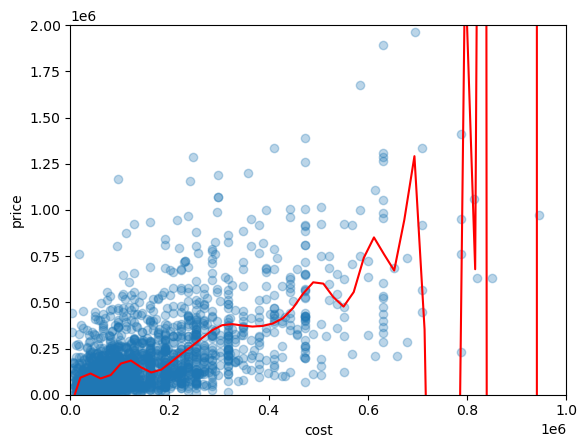

In [47]:
plot_cost_price(X_train.cost, y_train, model)
#x = np.linspace(0, 1e6)
#type(x)

# 2. Lasso

<font color='red'>Assignment:</font> Use **Lasso** instead of **LinearRegression** in **Pipeline** and redo the above steps. Tune **alpha** in **Lasso**, and find the answers to following questions.

In [52]:
from sklearn import linear_model

#just set alpha = 1.0
steps = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree=30)),
         ('rescale', MinMaxScaler()),
         ('la', linear_model.Lasso(alpha=1.0, max_iter=100000))]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

In [53]:
y_train_pred = model.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.09e+05
train MSE: 2.81e+10
train R2: 0.341


In [54]:
y_test_pred = model.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.35e+05
test MSE: 5.29e+10
test R2: 0.387


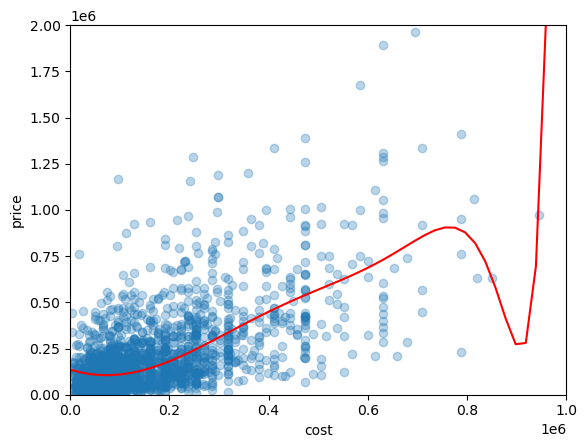

In [55]:
plot_cost_price(X_train.cost, y_train, model)

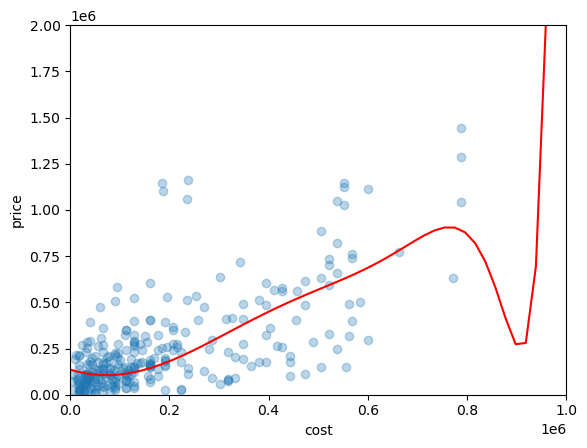

In [56]:
plot_cost_price(X_test.cost, y_test, model)

In [73]:
#tuning alpha in lasso

from sklearn.model_selection import RepeatedKFold, GridSearchCV

steps = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree=30)),
         ('rescale', MinMaxScaler()),
         ('la', linear_model.Lasso(max_iter=10000))]
model = Pipeline(steps)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0, 10, 101)
grid = dict()
grid['la__alpha'] = lasso_alphas 

search = GridSearchCV(model, param_grid = grid, scoring = 'neg_mean_absolute_error', \
                      cv = cv, n_jobs = -1, error_score = np.NaN).fit(X_train, y_train)

In [74]:
print('MAE: %.5f' % search.best_score_)
print('Config: %s' % search.best_params_)

MAE: -110697.38933
Config: {'la__alpha': 3.4000000000000004}


In [76]:
#fine-tune the alpha

steps = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree=30)),
         ('rescale', MinMaxScaler()),
         ('la', linear_model.Lasso(max_iter=10000))]
model = Pipeline(steps)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(3, 4, 101)
grid = dict()
grid['la__alpha'] = lasso_alphas 

search = GridSearchCV(model, param_grid = grid, scoring = 'neg_mean_absolute_error', \
                      cv = cv, n_jobs = -1, error_score = np.NaN).fit(X_train, y_train)

print('MAE: %.5f' % search.best_score_)
print('Config: %s' % search.best_params_)

MAE: -110692.56985
Config: {'la__alpha': 3.38}


In [77]:
y_test_pred = search.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.35e+05
test MSE: 5.39e+10
test R2: 0.375


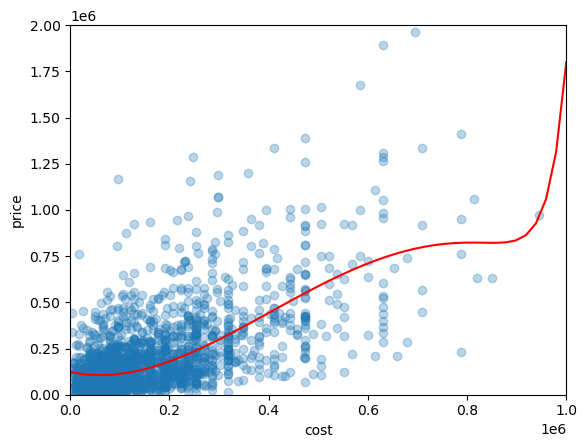

In [78]:
plot_cost_price(X_train.cost, y_train, search)

<font color='red'>Question:</font> **Alpha** is a hyper parameter. What is hyper parameter? How is it different from parameter?

In [80]:
#In machine learning, a hyper-parameter is used to control the learning process, while other parameter is derived from learning.

<font color='red'>Question:</font> How does **alpha** affect the train/test loss and variance/bias?

In [81]:
#when alpha = 0, it becomes (high order Polynomial) linear regression which very likely causes over-fitting, leading low train 
#loss but high test loss; it also causes low bias but high variance.
#when the value of alpha is properly tuned, the model is properly fited, leading low train loss and low test loss, 
#as well as low bias and low variance.
#An alpha value higher than the optimal causes under-fitting, leading both high train loss and high test loss, 
#as well as high bias and high variance.

<font color='red'>Question:</font> How dose **alpha** affect the relationship between **price** and **cost**? How does **alpha** affect model complexity?

In [ ]:
#Agian, alpha valued close to 0 will make the price-cost curve very soft, when over-valued alpha curve to a flat line. 
#The model complexity decreases as alpha increases.

<font color='red'>Question:</font> How does **alpha** affect the coefficient values?

In [82]:
#higher alpha tends to push the coeficient values to zeros, while small alpha likely to cuase high coefficient values when 
#data is noisy.

# 2. Ridge

<font color='red'>Assignment:</font> Try **Ridge** instead of **Lasso**.

In [84]:
steps = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree=30)),
         ('rescale', MinMaxScaler()),
         ('ri', linear_model.Ridge(max_iter=10000))]
model = Pipeline(steps)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ridge_alphas = np.linspace(0, 10, 101)
grid = dict()
grid['ri__alpha'] = ridge_alphas 

search = GridSearchCV(model, param_grid = grid, scoring = 'neg_mean_absolute_error', \
                      cv = cv, n_jobs = -1, error_score = np.NaN).fit(X_train, y_train)

In [85]:
print('MAE: %.5f' % search.best_score_)
print('Config: %s' % search.best_params_)

MAE: -112513.82422
Config: {'ri__alpha': 0.4}


In [86]:
#fine-tune the alpha
steps = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree=30)),
         ('rescale', MinMaxScaler()),
         ('ri', linear_model.Ridge(max_iter=10000))]
model = Pipeline(steps)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ridge_alphas = np.linspace(0.3, 0.5, 201)
grid = dict()
grid['ri__alpha'] = ridge_alphas 

search = GridSearchCV(model, param_grid = grid, scoring = 'neg_mean_absolute_error', \
                      cv = cv, n_jobs = -1, error_score = np.NaN).fit(X_train, y_train)

print('MAE: %.5f' % search.best_score_)
print('Config: %s' % search.best_params_)

MAE: -112513.81796
Config: {'ri__alpha': 0.399}


In [87]:
y_test_pred = search.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.36e+05
test MSE: 5.32e+10
test R2: 0.383


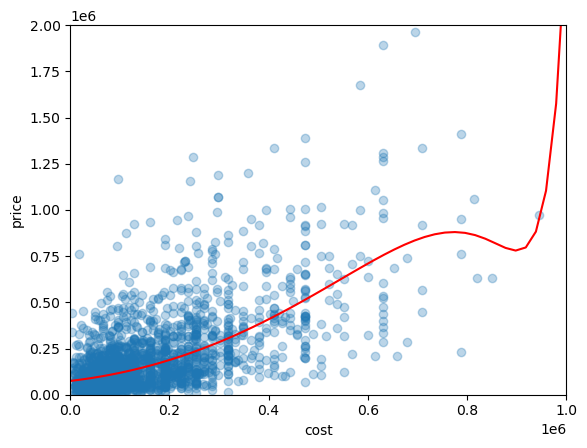

In [88]:
plot_cost_price(X_train.cost, y_train, search)

<font color='red'>Question:</font> What is regularization?

In [ ]:
#Regularization is refered to techniques that are used to calibrate machine learning model in order to minimize the adjusted 
#loss function and prevent overfitting or underfitting.

<font color='red'>Question:</font> How does regularization work?

In [ ]:
#Regularization adds a penalty to the loss function. The penalty equals a function (eg. sum of absoluted or sum of squared) 
#of the coefficients. So the penalty prevents overfitting which usually comes with very large coefficients, or increased 
#complexity of the model.

<font color='red'>Question:</font> What are "L1" and "L2" regularizations, respectively? How do they relate to **Ridge** and **Lasso**?

In [ ]:
# L1 regularization penalize the absolute value of the weight, it is also called regularization of sparsity. It forces the 
#weights of uninformative feacutes to be zero in a high-dimensional feature space.
#L2 regularization penalize the squared of the weight, it is also called regularization of simplicity. It forces the weight 
#towards zero but never make them to exactly to zero.
# Ridge is regression using L2 regularizations while Lasso is regression using L1 regularziations.

<font color='red'>Question:</font> What are the differeces between "L1" and "L2"? Why the difference between their effects on coefficient values?

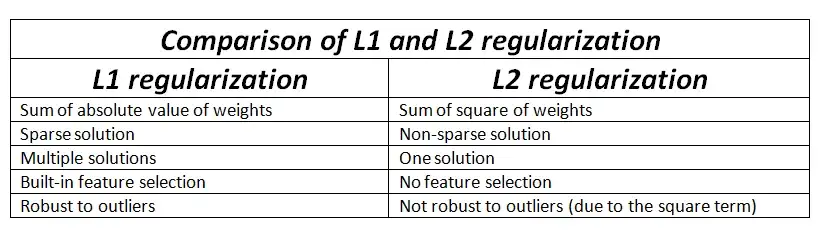

In [ ]:
#Also see answer to the above question.